# Sequential approach (SA) for modeling TRM dynamics

In the first part of the paper, we use a more traditional approach in which we first cluster the data, and then fit models to resulting timeseries. One issue with unsupervised clustering of TRM flow data is that e.g. Leiden cluster outcomes are highly dependent on the random number generator seed. We try to account for this by repeating the clustering 20 times, and then derive a consensus clustering to generate the timeseries. This requires some manual labor, and has been taken care of in the previous notebook (`SequentiaApproachClustering.ipynb`).

In this notebook we take the lower dimensional timeseries and fit a number of Stan ODE models to them. We then inspect the parameter estimates, and compare models with LOO-IC.

### Steps / pipeline

* Repeat Leiden clustering for a range of random seeds
* Try to find "robust / consensus" clusters
* Fit Stan models to the consensus cluster timeseries. **(this notebook)**
* Model comparison with LOO-IC **(this notebook)**

### Difficulties

* Fitting the model takes approx. 30 minutes, but in order to do a robust model comparison, we have to manually re-fit some of the models where we leave out observations. This is because pareto-smoothed importance sampling fails in some cases. This re-fitting can take a lot of time and is currently not implemented in a parallel way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import json
import arviz
import pickle

import scdynsys.plots as plots
import scdynsys.utilities as utils
import scdynsys.stanfit
    
# define colors for clsuters / celltypes

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

### Import data from the previous notebook

In which we consensus-clustered the single-cell flow data (`SequentialApproachClustering.ipynb`)

In [2]:
with open("../results/data_SA_clustering.pkl", "rb") as f:
    seq_data_dict = pickle.load(f)

count_df = seq_data_dict["count_df"]
freq_df = seq_data_dict["freq_df"]
cell_type_names = seq_data_dict["celltype_names"]
day_dict = seq_data_dict["mouse_day_dict"]

# make sure mice are sorted by day and then the ID
sorted_mice = sorted(list(day_dict.keys()), key=lambda x: (day_dict[x], int(x)))
num_cell_types = len(cell_type_names)

# define colors for plotting
celltype_color_dict = dict(zip(cell_type_names, tabcolors))

### Import cell count data

In [3]:
with open("../data/CD8_counts_Aug23.pkl", 'rb') as f:
    cell_counts = pickle.load(f)

### Use sampling days of each mouse to construct time series

Also process and plot the cell count data

Text(0.08, 0.5, 'fraction of cells')

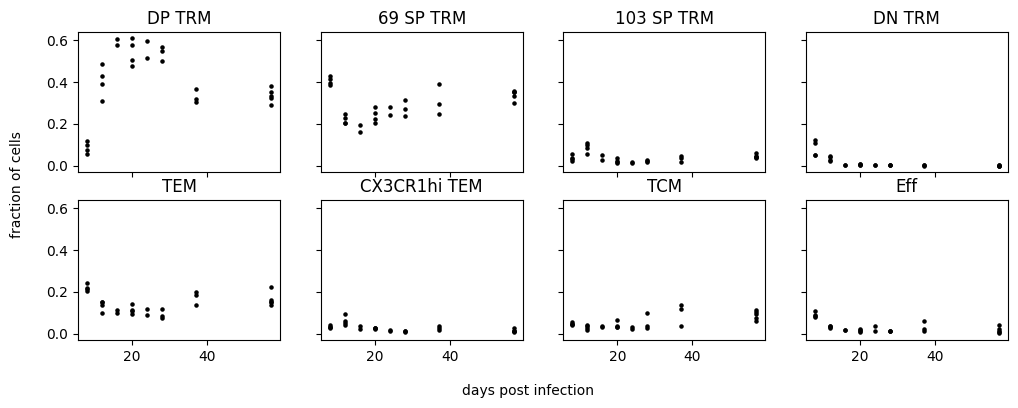

In [4]:
## compute and plot cluster frequencies

fig, axs = plt.subplots(2, 4, figsize=(12,4), sharey=True, sharex=True)

freq_df = count_df / count_df.sum(axis=0)

for i, ax in enumerate(axs.flatten()):
    if i >= num_cell_types:
        ax.axis("off")
        continue
    cell_type = cell_type_names[i]
    days = [day_dict[m] for m in sorted_mice]
    qs = freq_df[sorted_mice].loc[cell_type]
    ax.scatter(days, qs, s=5, c='k')
    ax.set_title(f"{cell_type}")
    
fig.text(0.5, 0.0, "days post infection", va='top', ha='center')
fig.text(0.08, 0.5, "fraction of cells", va='center', ha='right', rotation=90)

Text(0, 0.5, 'CD44+ I.V. neg CD8+ T cells')

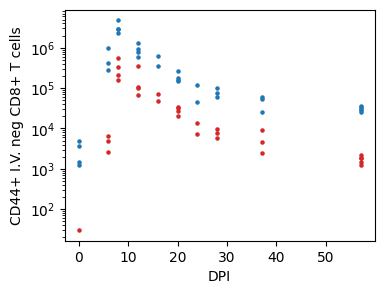

In [5]:
# cell count data

fig, ax = plt.subplots(1, 1, figsize=(4,3))

days = cell_counts["DPI"]
Ns = cell_counts['CD44+CD11a+_CD8']
tetpos_Ns = cell_counts['tetpos_CD8']
IDs = cell_counts["ID"]
incl_idxs = [i for i, b in enumerate(cell_counts["include"]) if b]

ax.scatter(days[incl_idxs], Ns[incl_idxs], color='tab:blue', s=5)
ax.scatter(days[incl_idxs], tetpos_Ns[incl_idxs], color='tab:red', s=5)
ax.set_yscale('log')

ax.set_xlabel("DPI")
ax.set_ylabel(f"CD44+ I.V. neg CD8+ T cells");

## Compile stan models, prepare data and fit

We consider 5 models: **Model "zero"** is a autonomous model without differentiation rates, for which we assume a multinomial observation model for the number of flow cytometry events per celltype. This model clearly underfits the data, as the multinomial is not capable of describing the variation between mice.

**Model I** fixes this by using a Dirichlet-Multinomial distribution, but this model still has a very simple time-independent loss rate and no differentiation is allowed.

**Model II** adds time-dependent loss rates, but has zero differentiation.

**Model III** assumes a time-independent loss rate, but instead allows for differentiation between cell types

Finally, **Model IV** incorporates both a time-dependent loss rate and allows for differentiation.

In [6]:
models = {
    "M0" : {
        "obs_model_freq" : "multinomial",
        "time_dependence" : "autonomous",
        "population_structure" : "independent",
    },
    "M1" : {
        "obs_model_freq" : "dirichlet_multinomial",
        "time_dependence" : "autonomous",
        "population_structure" : "independent"
    },
    "M2" : {
        "obs_model_freq" : "dirichlet_multinomial",
        "time_dependence" : "non_autonomous",
        "population_structure" : "independent"
    },  
    "M3" : {
        "obs_model_freq" : "dirichlet_multinomial",
        "time_dependence" : "autonomous",
        "population_structure" : "unrestricted",
    },
    "M4" : {
        "obs_model_freq" : "dirichlet_multinomial",
        "time_dependence" : "non_autonomous",
        "population_structure" : "unrestricted",
    },
}

### Use the `scdynsys.stanfit` module to fit the Stan models

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    Fitting the models might take some time. Especially model IV as it has the most parameters and requires numberical integration of ODEs
</div>

Executing this cell will create a directory `stan-cache` that stores all the fitting results.

These are some important parameters for the Stan fits

* `count_scaling` this is used to scale the total cell count during fitting. This might help with faster convergence. **It is however important to apply the reverse scaling with we want to plot the cell counts and fit.**
* `growth_rate_penalty` this is used to prevent model fits in which the total T cell count grows exponentially on the long term
* `T0` this is the initial starting time. It is important to specify this correctly because some models have time-dependent rates.

In [ ]:
model_names = sorted(list(models.keys()))

count_scaling = 1e6
growth_rate_penalty = 10
T0 = 8.0

fit_results = {}

stan_args = dict(
    iter_sampling=500,
    iter_warmup=500,
    adapt_delta=0.9, max_treedepth=12, step_size=0.05,
    chains=5,
    refresh=10,
    output_dir="../stan-cache/"
)

## NB: make sure the count_df is correctly sorted!

for m in model_names:
    print(f"============ fitting model {m} =============")
    fit_results[m] = scdynsys.stanfit.fit_stan_model(
        cell_counts["DPI"][incl_idxs], 
        cell_counts['CD44+CD11a+_CD8'][incl_idxs],
        [day_dict[mouse] for mouse in sorted_mice],
        count_df.loc[cell_type_names, sorted_mice].to_numpy(),
        T0,
        count_scaling=count_scaling,
        growth_rate_penalty = growth_rate_penalty,
        **models[m],
        excluded_obs_freq=[],
        **stan_args
    )

### Compare the 5 models based on ELDP

This shows which models fit the data best.

In [8]:
loo_results = {
    m : arviz.loo(fit_results[m][0]) 
    for m in model_names
}

comp_loo = arviz.compare(loo_results, method="BB-pseudo-BMA")

comp_loo

/home/chris/Repositories/scdynsys/venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/chris/Repositories/scdynsys/venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M4,0,-1215.948317,29.477370,0.000000,1.000000e+00,177.456657,0.000000,False,log
M2,1,-1253.929354,24.485075,37.981036,4.847555e-10,180.759621,9.489355,True,log
M3,2,-1288.464168,19.197164,72.515851,1.201797e-19,181.957327,13.101829,False,log
M1,3,-1371.627206,20.674195,155.678889,2.525910e-35,197.352530,29.363783,False,log
M0,4,-88674.915002,3548.309857,87458.966684,0.000000e+00,23101.342744,23707.853729,True,log


### Fix issues with LOO-CV

the leave-one-out cross validation reports some issues with Pareto-smoothed importance sampling.
We can fix those issues by doing "manual" leave-one-out cross validation: meaning that we 
actually leave the problematic data points out.

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    Running re-loo wcan take a lot of time. We have to fit the model many times.
    This is only used to create a model comparison table and is not required for other analyses.
</div>

Ideally, I would update this code to farm this out on a HPC.

In [ ]:
# compute loo and get bad pareto-k values

reloo_results = {
    m : scdynsys.stanfit.robust_looic(
        *fit_results[m],
        **stan_args
    )
    for m in model_names
}

In [11]:
## do model comparison with the refitted results

comp_reloo = arviz.compare(reloo_results, method="BB-pseudo-BMA")
display(comp_reloo)
print(comp_reloo.to_latex(float_format="{:0.1f}".format))

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M4,0,-1215.948317,29.477370,0.000000,1.000000e+00,180.590232,0.000000,False,log
M2,1,-1254.159610,24.715331,38.211293,1.757042e-10,184.372243,9.623211,True,log
M3,2,-1288.464168,19.197164,72.515851,5.635296e-19,185.807172,13.101829,False,log
M1,3,-1371.627206,20.674195,155.678889,7.942783e-39,198.601909,29.363783,False,log
M0,4,-111228.174269,26101.569124,110012.225951,0.000000e+00,32245.387238,32215.401272,True,log


\begin{tabular}{lrrrrrrrrl}
\toprule
 & rank & elpd_loo & p_loo & elpd_diff & weight & se & dse & warning & scale \\
\midrule
M4 & 0 & -1215.9 & 29.5 & 0.0 & 1.0 & 180.6 & 0.0 & False & log \\
M2 & 1 & -1254.2 & 24.7 & 38.2 & 0.0 & 184.4 & 9.6 & True & log \\
M3 & 2 & -1288.5 & 19.2 & 72.5 & 0.0 & 185.8 & 13.1 & False & log \\
M1 & 3 & -1371.6 & 20.7 & 155.7 & 0.0 & 198.6 & 29.4 & False & log \\
M0 & 4 & -111228.2 & 26101.6 & 110012.2 & 0.0 & 32245.4 & 32215.4 & True & log \\
\bottomrule
\end{tabular}



### Posterior predictive checks

A.K.A. model fits: Plot fitted trajectories against the data

**Select one of the models that we want to plot**

Here model IV is selected...

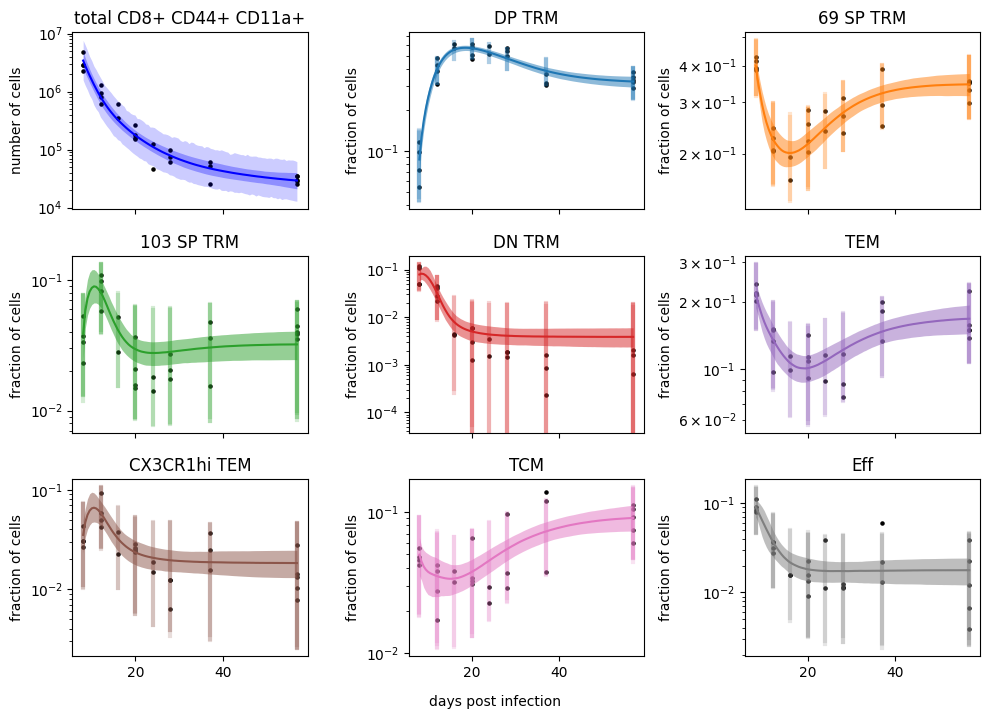

In [13]:
selected_model = "M4"

stan_fit, stan_inits, stan_data = fit_results[selected_model]

celltype_colors = [celltype_color_dict[ct] for ct in cell_type_names]

fig, axs = plots.plot_fits_sequential(
    stan_fit, stan_data,
    cell_type_names,
    count_scaling=count_scaling,
    color=celltype_colors
)


fig.text(0.5, 0.0, "days post infection", va='top', ha='center')
fig.align_ylabels()

fig.tight_layout()

### Plot time-dependent growth rates

The Stan model computes loss rates at each time point. These also include differentiation rates (influx and efflux)

In the manuscript, we report rates in terms of loss rates $\lambda$. We coded the model in terms of the growth rates instead. This growth rate is called $\rho$ ($\rho$ has another meaning in the manuscript)

In [ ]:
cols = 3 # number of columns in the figure
nax = num_cell_types
rows = nax // cols + (0 if nax % cols == 0 else 1)
fig, axs = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)

rates = stan_fit.stan_variable("rates")

for i, ax in enumerate(axs.flatten()):
    if i >= num_cell_types:
        ax.axis('off')
        continue
    ct = cell_type_names[i]
    ## plot prediction
    lr, mr, hr = np.percentile(rates[:,i,:], axis=0, q=[2.5, 50, 97.5])
    ax.plot(stan_data["Tsim"], mr, color=celltype_color_dict[ct])
    ax.fill_between(stan_data["Tsim"], lr, hr, alpha=0.5, linewidth=0, color=celltype_color_dict[ct])
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.set_title(ct)
    
fig.tight_layout()
fig.text(-0.01, 0.5, "expansion or decay rate of celltype ($\\rho(t)$ per day)", rotation=90, va='center')
fig.text(0.5, 0.0, "DPI ($t$)", ha='center')

## Save data and parameters for the notebook in which we make the SA fits figure.

To save the fits, we don't pickle CmdStanPy objects, but first extract dictionaries.
Pickles with complex python objects can get "corrupted" if we upgrade the `cmdstanpy` version.
I found this out the hard way.

In [14]:
fit_results_simplified = {
    k : (v[0].stan_variables(), v[1], v[2], v[0].method_variables())
    for k, v in fit_results.items()
}

seq_fit_data_dict = {
    "fit_results" : fit_results_simplified,
    "celltype_names" : cell_type_names,
    "count_scaling" : count_scaling
}

with open("../results/data_SA_fitting.pkl", 'wb') as f:
    pickle.dump(seq_fit_data_dict, f)

## Inspect parameter estimates

Here we can do further model inspection: look at parameter estimates and posterior correlations.

In the manuscript, we use different names for the parameters. Here's a table to translate...

| code name | manuscript name |
|-----------|-----------------|
| $\rho$    | $\lambda_E$     |
| $\eta$    | $\lambda_L$     |
| $\delta$  | $Q_{ij}$ with $i\neq j$ |
| $\sigma_c$ | $\sigma_M$     |
| $\phi_f$   | $\tau_K$  |

as $\rho$ is also used for the time-dependent rate, we use $\rho_0$ to indicate $\lambda_E$ as well.

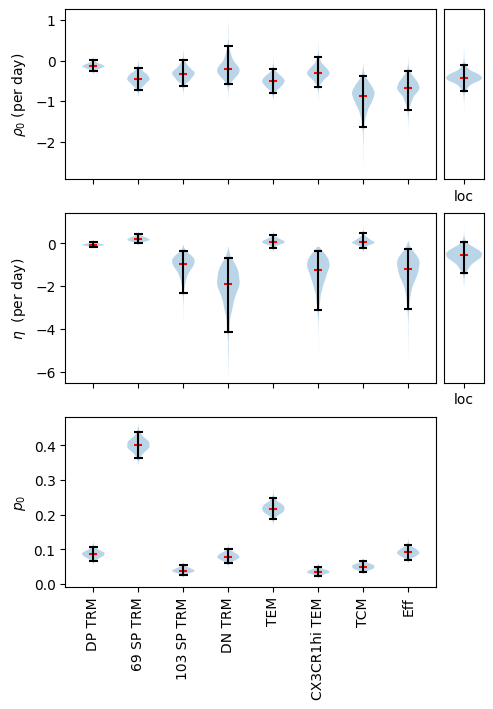

In [15]:
pos = [i for i, _ in enumerate(cell_type_names)]
xlabs = cell_type_names

sam = fit_results[selected_model][0]

rho = sam.stan_variable("rho")
rho_loc = sam.stan_variable("rho_loc")
eta = sam.stan_variable("eta")
eta_loc = sam.stan_variable("eta_loc")
p0 = sam.stan_variable("p0")


Q = sam.stan_variable("Q")
mQ = np.mean(Q, axis=0)

ylabs = ["$\\rho_0$ (per day)", "$\\eta$  (per day)", "$p_0$"]

fig, axs, bxs = plots.plot_mpd_array(
    [rho, eta, p0], 
    [rho_loc, eta_loc, None],
    pos, 
    xlabs, 
    ylabs
)

fig.align_ylabels()

### Compute some stats

Point estimates and CrI for the loss rates. Also convert to t1/2s (report in the text)
for specific populations

More statistics are calculated below...

In [16]:
u = sam.stan_variable("u")

u_CrI = np.percentile(u, q=[2.5, 97.5])
u_med = np.percentile(u, q=50.0)

print("u:", u_med, u_CrI)

alpha = 0.5
print(f"t{alpha} u:", -np.log(alpha)/u_med, -np.log(alpha) / u_CrI)

print("=====================")


## half-life of populations

i = cell_type_names.index("69 SP TRM")
print("half life of", cell_type_names[i])
eta_i = eta[:,i]
eta_CrI = np.percentile(eta_i, q=[2.5, 97.5])
eta_med = np.percentile(eta_i, q=50.0)

print("eta:", eta_med, eta_CrI)
print(f"t{alpha} eta:", np.log(alpha)/eta_med, np.log(alpha)/eta_CrI)

print("=====================")

## half-life of populations

i = cell_type_names.index("TEM")
print("half life of", cell_type_names[i])
eta_i = eta[:,i]
eta_CrI = np.percentile(eta_i, q=[2.5, 97.5])
eta_med = np.percentile(eta_i, q=50.0)

print("eta:", eta_med, eta_CrI)
print(f"t{alpha} eta:", np.log(alpha)/eta_med, np.log(alpha)/eta_CrI)

u: 0.1095725 [0.0685313  0.17558753]
t0.5 u: 6.325922841588403 [10.1143161   3.94758785]
half life of 69 SP TRM
eta: 0.1942955 [0.01865081 0.427639  ]
t0.5 eta: -3.56748962564725 [-37.16445953  -1.62086989]
half life of TEM
eta: 0.0807583 [-0.20807243  0.3721429 ]
t0.5 eta: -8.582983799311592 [ 3.33127843 -1.86258338]


### Plot the differentiation matrix

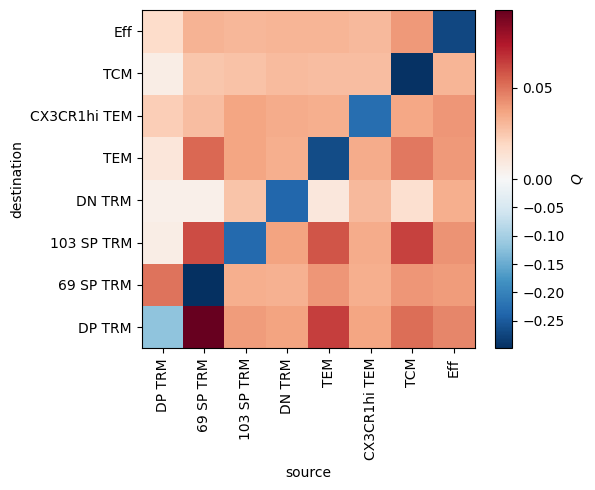

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

Q = sam.stan_variable("Q")
mQ = np.mean(Q, axis=0)

# some models do not have differentiation... Skip plotting for these.

if any(mQ.flatten() > 0):
    divnorm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(mQ), vcenter=0, vmax=np.max(mQ))
    cs = ax.pcolor(mQ, cmap="RdBu_r", norm=divnorm)
    cb = fig.colorbar(cs)
    cb.set_label("$Q$")
    
pos = np.linspace(0, num_cell_types-1, num_cell_types) + 0.5
ax.set_xticks(pos)
ax.set_xticklabels(cell_type_names, rotation=90)
ax.set_yticks(pos)
ax.set_yticklabels(cell_type_names)

ax.set_xlabel("source")
ax.set_ylabel("destination")

fig.tight_layout()

### Plot marginal posterior densities of differentiation rates.

Plot denisties of $Q_{ij}$ for $i \neq j$

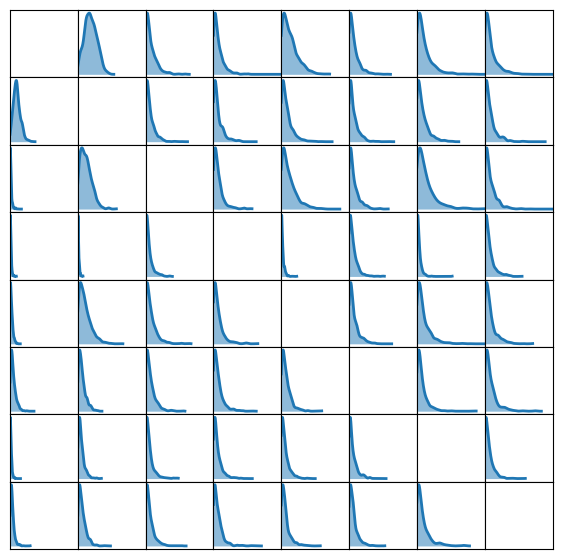

In [18]:
fig, axs = plt.subplots(*Q.shape[1:], sharex=True, sharey=False, figsize=(7,7))

fig.subplots_adjust(wspace=0, hspace=0)

for i in range(Q.shape[1]):
    for j in range(Q.shape[2]):
        ax = axs[i,j]
        ax.set_yticks([])
        if i == j:
            continue
        Qij = Q[:,i,j]
        if len(set(Qij)) > 1:
            plots.density_plot(ax,  Qij)
    ax.set_xlim(0, 0.5)
    ax.set_xticks([])

### Make a table with some of the estimates

Calculate some point estimates and CrI that we may want to refer to in the manuscript
E.g. for $\sigma$, $u$, $\phi$

In [19]:
par_names = ["u", "sigma_c", "phi_inv_f"]
model_ids = ["M1", "M2", "M3", "M4"]

transf = {
    "u" : lambda x: np.log(2) / x,
    "sigma_c" : lambda x: x,
    "phi_inv_f" : lambda x: 1/x
}

for M in model_ids:
    fit_res, _, _ = fit_results[M]
    ests = fit_res.stan_variables()
    for p in par_names:
        psams = transf[p](ests[p])
        lo, med, hi = np.percentile(psams, axis=0, q=[2.5, 50, 97.5])
        print(f"{M}, {p}, est: {med:0.2f}, CrI: [{lo:0.2f}, {hi:0.2f}]")
    

M1, u, est: 1.06, CrI: [0.31, 23.95]
M1, sigma_c, est: 0.85, CrI: [0.66, 1.16]
M1, phi_inv_f, est: 40.25, CrI: [33.67, 47.38]
M2, u, est: 2.18, CrI: [1.65, 2.83]
M2, sigma_c, est: 0.54, CrI: [0.40, 0.75]
M2, phi_inv_f, est: 119.72, CrI: [97.23, 146.94]
M3, u, est: 1.03, CrI: [0.31, 16.69]
M3, sigma_c, est: 0.62, CrI: [0.47, 0.87]
M3, phi_inv_f, est: 83.77, CrI: [67.55, 102.76]
M4, u, est: 6.33, CrI: [3.95, 10.11]
M4, sigma_c, est: 0.35, CrI: [0.26, 0.51]
M4, phi_inv_f, est: 165.37, CrI: [131.42, 205.84]


### 1-1 model comparison

For the logic of the manuscript, we also want 1-1 model comparisons

In [20]:
## pairwise model comparison

comps = scdynsys.stanfit.pairwise_loo_comparison(
    loo_results, # ideally, do this with reloo_results
    models=["M1", "M2", "M3", "M4"]
)

for comp in comps:
    display(comp)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M2,0,-1253.929354,24.485075,0.000000,1.000000e+00,189.271981,0.000000,True,log
M1,1,-1371.627206,20.674195,117.697853,4.828356e-18,206.540337,29.062502,False,log


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M3,0,-1288.464168,19.197164,0.000000,1.000000e+00,188.374879,0.000000,False,log
M1,1,-1371.627206,20.674195,83.163038,5.707228e-14,203.671556,27.968223,False,log


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M2,0,-1253.929354,24.485075,0.000000,0.994015,180.045467,0.000000,True,log
M3,1,-1288.464168,19.197164,34.534814,0.005985,180.721587,13.051224,False,log


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M4,0,-1215.948317,29.477370,0.000000,1.000000e+00,176.761958,0.000000,False,log
M1,1,-1371.627206,20.674195,155.678889,4.426793e-31,196.061951,29.363783,False,log


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M4,0,-1215.948317,29.477370,0.000000,1.000000e+00,180.656671,0.000000,False,log
M2,1,-1253.929354,24.485075,37.981036,7.014123e-09,183.797406,9.489355,True,log


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M4,0,-1215.948317,29.477370,0.000000,1.000000e+00,184.631553,0.000000,False,log
M3,1,-1288.464168,19.197164,72.515851,5.200097e-18,189.308282,13.101829,False,log


### Inspect posterior correlations between parameters

correlations in eta, rho and Q

If correlations are very close to 1, this might indicate identifiability issues

(2500, 25)


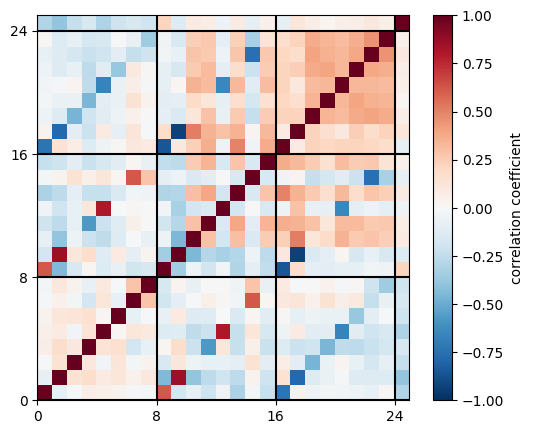

In [21]:
sam = fit_results[selected_model][0]

rho = sam.stan_variable("rho")
eta = sam.stan_variable("eta")
delta_raw = sam.stan_variable("delta_raw")
diag_Q = np.diagonal(sam.stan_variable("Q"), axis1=-1, axis2=-2)
logY0 = np.expand_dims(sam.stan_variable("logY0"), 1)
theta = np.concatenate([rho.T, eta.T, diag_Q.T, logY0.T]).T

print(theta.shape)

Rmat = np.corrcoef(theta.T)

fig, ax = plt.subplots(1, 1, figsize=(6, 5)) 

cc = ax.pcolor(Rmat, cmap='RdBu_r', vmin=-1, vmax=1)
cx = fig.colorbar(cc)
cx.set_label("correlation coefficient")

ticks = [0, 8, 16, 24]
for t in ticks:
    ax.axvline(t, color='k')
    ax.axhline(t, color='k')
ax.set_xticks(ticks)
ax.set_yticks(ticks);

### Plot marginal distributions of some of the other parameters

location, scale, error model parameters.

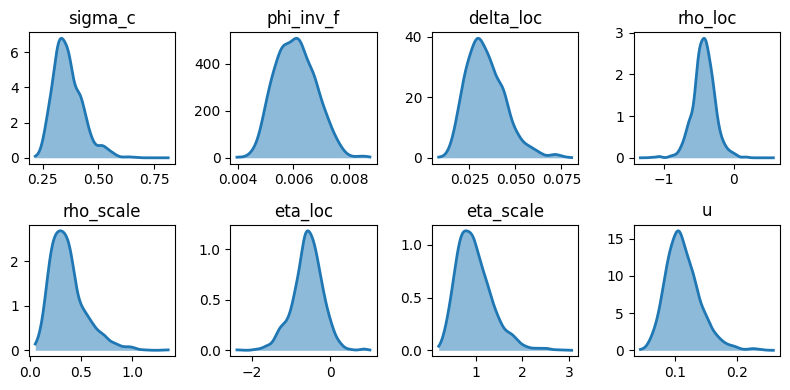

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(8,4))

varnames = ["sigma_c", "phi_inv_f", "delta_loc", "rho_loc", "rho_scale", "eta_loc", "eta_scale", "u"]

for varname, ax in zip(varnames, axs.flatten()):
    xs = sam.stan_variable(varname)
    plots.density_plot(ax, xs)
    ax.set_title(varname)

fig.tight_layout()